## Libraries

In [1]:
import os
import os.path
import random
import math
import cv2

import matplotlib.pyplot as plt
import numpy as np
import tifffile as tiff
import imagecodecs


import tensorflow as tf
from tensorflow.keras.layers     import BatchNormalization
from tensorflow.keras.models     import Model
from tensorflow.keras.layers     import (Input,
                                                Conv2D,
                                                MaxPooling2D,
                                                UpSampling2D,
                                                concatenate,
                                                Conv2DTranspose,
                                                Dropout)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks  import (CSVLogger,
                                                ModelCheckpoint,
                                                EarlyStopping,
                                                ReduceLROnPlateau,
                                                TensorBoard)
from tensorflow.keras.metrics import MeanIoU

2024-01-28 10:35:58.810284: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Generating patches

In [4]:
DEFAULT_PATCH_SIZE = 320

"""
Returns a random augmented patch from the image

img:     numpy array of shape (x_size, y_size, nb_channels)
mask:    binary (one-hot) numpy array of shape (x_size, y_size, nb_classes)
size:    size of random patch (square)

returns: patch with shape(size, size, nb_channels) and its mask
"""

# def add_random_brightness(image, brightness_range=0.2):
#     factor = 1 + np.random.uniform(-brightness_range, brightness_range)
#     return np.clip(image * factor, 0, 255)

# def add_random_contrast(image, contrast_range=0.2):
#     mean = np.mean(image)
#     factor = 1 + np.random.uniform(-contrast_range, contrast_range)
#     return np.clip((image - mean) * factor + mean, 0, 255)

# def add_gaussian_blur(image, max_kernel_size=5):
#     if np.random.rand() < 0.5:
#         kernel_size = np.random.choice(range(1, max_kernel_size, 2))
#         image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)
#     return image

# def add_random_noise(image, noise_factor=0.05):
#     noise = np.random.randn(*image.shape) * noise_factor
#     return np.clip(image + noise, 0, 255)

def get_rand_patch(img, mask, size=DEFAULT_PATCH_SIZE):
    assert len(img.shape) == 3     \
           and img.shape[0] > size \
           and img.shape[1] > size \
           and img.shape[0:2] == mask.shape[0:2]

    # SpaceNet images have 8 bands, we take only 3

    xs = random.randint(0, img.shape[0] - size)
    ys = random.randint(0, img.shape[1] - size)
    patch_img  = img[xs:xs+size, ys:ys+size]
    patch_mask = mask[xs:xs+size, ys:ys+size]

    # apply random transformations
    rt = np.random.randint(0, 7)
    if rt == 0:
        # horizontal flip
        patch_img  = patch_img[::-1, :, :]
        patch_mask = patch_mask[::-1, :, :]
    elif rt == 1:
        # vertical flip
        patch_img  = patch_img[:, ::-1, :]
        patch_mask = patch_mask[:, ::-1, :]
    elif rt == 2:
        # transpose
        patch_img = patch_img.transpose([1, 0, 2])
        patch_mask = patch_mask.transpose([1, 0, 2])
    elif rt == 3:
        # 90 degree rotation
        patch_img = np.rot90(patch_img, 1)
        patch_mask = np.rot90(patch_mask, 1)
    elif rt == 4:
        # 180 degree rotation
        patch_img = np.rot90(patch_img, 2)
        patch_mask = np.rot90(patch_mask, 2)
    elif rt == 5:
        # 270 degree rotation
        patch_img = np.rot90(patch_img, 3)
        patch_mask = np.rot90(patch_mask, 3)
    else:
        # no transformation
        pass
    # if np.random.rand() < 0.5: # 50% chance to apply brightness adjustment
    #     patch_img = add_random_brightness(patch_img)

    # if np.random.rand() < 0.5: # 50% chance to apply contrast adjustment
    #     patch_img = add_random_contrast(patch_img)

    # if np.random.rand() < 0.5: # 50% chance to apply Gaussian blur
    #     patch_img = add_gaussian_blur(patch_img)

    # if np.random.rand() < 0.5: # 50% chance to apply random noise
    #     patch_img = add_random_noise(patch_img)

    return patch_img, patch_mask

In [5]:
"""
returns specified number of patches

x_dict:     (input) image dictionary (image_id -> image)
y_dict:     (output) mask dictionary (image_id -> image)
nb_pathces: number of patches to return
size:       size of patches

returns:    x and y, both numpy arrays of shape
            (nb_patches, patch_size, patch_size, nb_channels)
"""
def get_patches(x_dict, y_dict, nb_patches, size=DEFAULT_PATCH_SIZE):
    x = []
    y = []
    total_patches = 0
    
    while total_patches < nb_patches:
        img_id = random.sample(x_dict.keys(), 1)[0]
        img  = x_dict[img_id]
        mask = y_dict[img_id]
        img_patch, mask_patch = get_rand_patch(img, mask, size)
        x.append(img_patch)
        y.append(mask_patch)
        total_patches += 1
    
    print("Generated {} patches".format(total_patches))
    
    return np.array(x), np.array(y)

##  U-Net model

In [7]:
"""
U-Net model (https://arxiv.org/abs/1505.04597)
"""
def unet_model(nb_classes=3, img_size=DEFAULT_PATCH_SIZE, nb_channels=5, nb_filters_start=32,
              growth_factor=2, upconv=True, droprate=0.4, class_weights= [2, 1, 2]):
    nb_filters = nb_filters_start
    inputs = Input(shape=(img_size, img_size, nb_channels))
    conv1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    
    nb_filters *= growth_factor
    pool1 = BatchNormalization()(pool1)
    conv2 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    pool2 = Dropout(droprate)(pool2)

    nb_filters *= growth_factor
    pool2 = BatchNormalization()(pool2)
    conv3 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    pool3 = Dropout(droprate)(pool3)

    nb_filters *= growth_factor
    pool3 = BatchNormalization()(pool3)
    conv4_0 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(pool3)
    conv4_0 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv4_0)
    pool4_1 = MaxPooling2D(pool_size=(2, 2))(conv4_0)
    pool4_1 = Dropout(droprate)(pool4_1)

    nb_filters *= growth_factor
    pool4_1 = BatchNormalization()(pool4_1)
    conv4_1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(pool4_1)
    conv4_1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv4_1)
    pool4_2 = MaxPooling2D(pool_size=(2, 2))(conv4_1)
    pool4_2 = Dropout(droprate)(pool4_2)

    nb_filters *= growth_factor
    conv5 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(pool4_2)
    conv5 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv5)
    
    
    # this is the bottom part of "U"
        
    
    nb_filters //= growth_factor
    if upconv:
        up6_1 = concatenate([Conv2DTranspose(nb_filters, (2, 2), strides=(2, 2), padding='same')(conv5), conv4_1])
    else:
        up6_1 = concatenate([UpSampling2D(size=(2, 2))(conv5), conv4_1])
        
    up6_1 = BatchNormalization()(up6_1)
    conv6_1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(up6_1)
    conv6_1 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv6_1)
    conv6_1 = Dropout(droprate)(conv6_1)
    
    nb_filters //= growth_factor
    if upconv:
        up6_2 = concatenate([Conv2DTranspose(nb_filters, (2, 2), strides=(2, 2), padding='same')(conv6_1), conv4_0])
    else:
        up6_2 = concatenate([UpSampling2D(size=(2, 2))(conv6_1), conv4_0])
    up6_2 = BatchNormalization()(up6_2)
    conv6_2 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(up6_2)
    conv6_2 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv6_2)
    conv6_2 = Dropout(droprate)(conv6_2)
    
    nb_filters //= growth_factor
    if upconv:
        up7 = concatenate([Conv2DTranspose(nb_filters, (2, 2), strides=(2, 2), padding='same')(conv6_2), conv3])
    else:
        up7 = concatenate([UpSampling2D(size=(2, 2))(conv6_2), conv3])
    up7 = BatchNormalization()(up7)
    conv7 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv7)
    conv7 = Dropout(droprate)(conv7)
    
    nb_filters //= growth_factor
    if upconv:
        up8 = concatenate([Conv2DTranspose(nb_filters, (2, 2), strides=(2, 2), padding='same')(conv7), conv2])
    else:
        up8 = concatenate([UpSampling2D(size=(2, 2))(conv7), conv2])
    up8 = BatchNormalization()(up8)
    conv8 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv8)
    conv8 = Dropout(droprate)(conv8)

    nb_filters //= growth_factor
    if upconv:
        up9 = concatenate([Conv2DTranspose(nb_filters, (2, 2), strides=(2, 2), padding='same')(conv8), conv1])
    else:
        up9 = concatenate([UpSampling2D(size=(2, 2))(conv8), conv1])
    conv9 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(nb_filters, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(nb_classes, (1, 1), activation='softmax')(conv9)

    model = Model(inputs=inputs, outputs=conv10)
    
    def weighted_binary_crossentropy(y_true, y_pred):
        class_loglosses = tf.reduce_mean(tf.keras.backend.binary_crossentropy(y_true, y_pred), axis=[0, 1, 2])
        return tf.reduce_sum(class_loglosses * tf.constant(class_weights))

    
    model.compile(optimizer=Adam(lr=0.0001), 
              loss='binary_crossentropy', 
              metrics=['accuracy', tf.keras.metrics.MeanIoU(num_classes=NB_CLASSES)])

    
    return model

## Training

In [6]:
from tensorflow.keras.callbacks import Callback
import numpy as np

class CustomModelCheckpoint(Callback):
    def __init__(self, save_path, start_epoch=10, min_delta=0.1):
        super(CustomModelCheckpoint, self).__init__()
        self.save_path = save_path
        self.start_epoch = start_epoch
        self.min_delta = min_delta
        self.best_loss = np.inf

    def on_epoch_end(self, epoch, logs=None):
        current_loss = logs.get('val_loss')
        if epoch + 1 >= self.start_epoch and current_loss < self.best_loss - self.min_delta:
            self.best_loss = current_loss
            self.model.save(self.save_path)
            print(f"Checkpoint saved at epoch {epoch + 1}")



In [ ]:
"""
returns image normalized to be in [-1, 1]
"""
def normalize(img):
    minv = img.min()
    maxv = img.max()
    return 2.0 * (img - minv) / (maxv - minv) - 1.0


NB_BANDS      = 5
NB_CLASSES    = 3   
CLASS_WEIGHTS = [2, 1, 2]
NB_EPOCHS     = 60
BATCH_SIZE    = 8
UPCONV        = True
PATCH_SIZE    = 320  # should be divisible by 16
NB_TRAIN      = 800
NB_VAL        = 200


def get_model():
    return unet_model(NB_CLASSES, PATCH_SIZE, nb_channels=NB_BANDS, upconv=UPCONV, class_weights=CLASS_WEIGHTS)


data_path = 'GP'
weights_path = 'weights'
if not os.path.exists(weights_path):
    os.makedirs(weights_path)
weights_path = os.path.join(weights_path, 'unet_weights_final.hdf5')

# train_ids = [str(i).zfill(2) for i in range(1, 14)]  # all image ids: from 01 to 25
train_ids = ['01']  #Only 1


# if __name__ == '__main__':

X_DICT_TRAIN = dict()
Y_DICT_TRAIN = dict()
X_DICT_VAL   = dict()
Y_DICT_VAL   = dict()

print("Reading images")
for img_id in train_ids:
    img_m = normalize(tiff.imread(os.path.join(data_path, 'mband/{}.tif'.format(img_id))).transpose([1, 2, 0]))
    mask = tiff.imread(os.path.join(data_path, 'gt_mband/{}.tif'.format(img_id))).transpose([1, 2, 0]) / 255
    
    print("DEBUG:", "img_m.shape =", img_m.shape, " mask.shape =", mask.shape)

        # Add this check
    if img_m.shape[0:2] != mask.shape[0:2]:
        print(f"Mismatch in dimensions for image ID {img_id}: Image shape {img_m.shape[0:2]}, Mask shape {mask.shape[0:2]}")



    # use 75% of image for training and 25% for validation
    train_size = int(4/5 * img_m.shape[0])
    X_DICT_TRAIN[img_id] = img_m[:train_size, :, :]
    Y_DICT_TRAIN[img_id] = mask [:train_size, :, :]
    X_DICT_VAL[img_id]   = img_m[train_size:, :, :]
    Y_DICT_VAL[img_id]   = mask [train_size:, :, :]

    print("Read " + img_id)

print("Done reading images")


def train_net():
    print("Started training")

    x_train, y_train = get_patches(X_DICT_TRAIN, Y_DICT_TRAIN, nb_patches=NB_TRAIN, size=PATCH_SIZE)
    x_val,   y_val   = get_patches(X_DICT_VAL,   Y_DICT_VAL,   nb_patches=NB_VAL,   size=PATCH_SIZE)

    model = get_model()

    # load saved weights
    if os.path.isfile(weights_path):
        model.load_weights(weights_path)

    # model_checkpoint = ModelCheckpoint(weights_path, monitor='val_loss', save_best_only=True)
    custom_checkpoint = CustomModelCheckpoint(weights_path, start_epoch=40, min_delta=0.001)
    csv_logger = CSVLogger('log_unet.csv', append=True, separator=',')
    tensorboard = TensorBoard(log_dir='./tensorboard_unet/', write_graph=True, write_images=True)


    model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=NB_EPOCHS,
              verbose=2, shuffle=True, callbacks=[custom_checkpoint, csv_logger],
              validation_data=(x_val, y_val))

    return model


train_net()

## Predicting

In [16]:
NB_BANDS      = 5
NB_CLASSES    = 3   
CLASS_WEIGHTS = [2, 1, 2]
NB_EPOCHS     = 60
BATCH_SIZE    = 8
UPCONV        = True
PATCH_SIZE    = 320  # should be divisible by 16
NB_TRAIN      = 800
NB_VAL        = 200

def normalize(img):
    minv = img.min()
    maxv = img.max()
    return 2.0 * (img - minv) / (maxv - minv) - 1.0
    
def get_model():
    return unet_model(NB_CLASSES, PATCH_SIZE, nb_channels=NB_BANDS, upconv=UPCONV, class_weights=CLASS_WEIGHTS)


data_path = 'GP'
weights_path = 'weights'

In [17]:
"""
runs model in inference mode on given input x
"""
def predict(x, model, patch_size=320, nb_classes=3):
    
    img_height = x.shape[0]
    img_width = x.shape[1]
    nb_channels = x.shape[2]
    
    # extend image so that it contains integer number of patches
    nb_patches_vertical = math.ceil(img_height / patch_size)
    nb_patches_horizontal = math.ceil(img_width / patch_size)
    extended_height = patch_size * nb_patches_vertical
    extended_width = patch_size * nb_patches_horizontal
    ext_x = np.zeros((extended_height, extended_width, nb_channels), dtype=np.float32)
    
    # fill extended image with mirrors
    ext_x[:img_height, :img_width, :] = x
    for i in range(img_height, extended_height):
        mirror_i = img_height - (i - img_height) % img_height - 1
        ext_x[i, :, :] = ext_x[mirror_i, :, :]

    for j in range(img_width, extended_width):
        mirror_j = img_width - (j - img_width) % img_width - 1
        ext_x[:, j, :] = ext_x[:, mirror_j, :]

    
    patches_list = []
    for i in range(nb_patches_vertical):
        for j in range(nb_patches_horizontal):
            x0, x1 = i * patch_size, (i + 1) * patch_size
            y0, y1 = j * patch_size, (j + 1) * patch_size
            patches_list.append(ext_x[x0:x1, y0:y1, :])
    
    # model.predict() requires a numpy array
    patches = np.asarray(patches_list)
    
    # predictions (no overlap)
    patches_predict = model.predict(patches, batch_size=4)
    prediction = np.zeros((extended_height, extended_width, nb_classes), dtype=np.float32)
    for k in range(patches_predict.shape[0]):
        i = k // nb_patches_horizontal  # Corrected: vertical index
        j = k % nb_patches_horizontal   # Corrected: horizontal index
        x0, x1 = i * patch_size, (i + 1) * patch_size
        y0, y1 = j * patch_size, (j + 1) * patch_size
        prediction[x0:x1, y0:y1, :] = patches_predict[k, :, :, :]

    return prediction[:img_height, :img_width, :]

In [18]:
"""
returns an RGB image with color-coded classes based on mask

mask: mask of shape (height, width, nb_classes)
"""
def picture_from_mask(mask, threshold=0):
    colors = {
        0: [0, 0, 255], 
        1: [255, 0, 0],   
        2: [0, 255, 0],    
    }
    z_order = {
        1: 0,
        2: 1,
        3: 2,
    }

    pict = 255 * np.ones((3, mask.shape[1], mask.shape[2]), dtype=np.uint8)
    for i in range(1, 4):
        cl = z_order[i]
        for ch in range(3):
            pict[ch, :, :][mask[cl, :, :] > threshold] = colors[cl][ch]
    return pict

In [ ]:
# test on an image
model = get_model()
model.load_weights(weights_path)
test_id = '01'
img = normalize(tiff.imread(os.path.join(data_path, 'mband/{}.tif'.format(test_id))).transpose([1, 2,0]))   # make channels last


# predict for transformed input image and take the average
for i in range(7):
    if i == 0:
        # reverse first dimension
        mymat = predict(img[::-1,:,:], model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES).transpose([2,0,1])
        print("Case 1",img.shape, mymat.shape)
    elif i == 1:
        # reverse second dimension
        temp = predict(img[:,::-1,:], model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES).transpose([2,0,1])
        print("Case 2", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ temp[:,::-1,:], mymat ]), axis=0 )
    elif i == 2:
        # transpose (interchange) first and second dimensions
        temp = predict(img.transpose([1,0,2]), model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES).transpose([2,0,1])
        print("Case 3", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ temp.transpose(0,2,1), mymat ]), axis=0 )
    elif i == 3:
        temp = predict(np.rot90(img, 1), model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES)
        print("Case 4", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ np.rot90(temp, -1).transpose([2,0,1]), mymat ]), axis=0 )
    elif i == 4:
        temp = predict(np.rot90(img,2), model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES)
        print("Case 5", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ np.rot90(temp,-2).transpose([2,0,1]), mymat ]), axis=0 )
    elif i == 5:
        temp = predict(np.rot90(img,3), model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES)
        print("Case 6", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ np.rot90(temp, -3).transpose(2,0,1), mymat ]), axis=0 )
    else:
        temp = predict(img, model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES).transpose([2,0,1])
        print("Case 7", temp.shape, mymat.shape)
        mymat = np.mean( np.array([ temp, mymat ]), axis=0 )

map_ = picture_from_mask(mymat, 0.5)

tiff.imsave('result.tif', (255 * mymat).astype('uint8'))
tiff.imsave('map.tif', map_)

In [10]:
!mkdir results

mkdir: cannot create directory ‘results’: File exists


In [19]:
weights_path = 'path/to/your/weights'  # Set the path to your weights file
file_path = 'path/to/your/file.tif'    # Set the path to your TIFF file

model = get_model()
model.load_weights(weights_path)

print("processing {}".format(file_path))
inp = normalize(tiff.imread(file_path).transpose([1, 2, 0]))
res = predict(inp, model, patch_size=PATCH_SIZE, nb_classes=NB_CLASSES).transpose([2, 0, 1])
res_map = picture_from_mask(res, 0.5)
tiff.imsave('result.tif', res_map)  # The result is saved in the current directory


processing 01.tif


2024-01-28 10:38:34.295959: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8800
2024-01-28 10:38:34.716568: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory


32/32 [==============================] - 4s 57ms/step


/tmp/ipykernel_3791/3142861810.py:11: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tiff.imsave('results/result_{}.tif'.format(num), res_map)


In [10]:
!tar -zcf results.tar.gz results

In [37]:
def display_band_of_whole_image(image, band_index=4):
    """
    Display a specified band of the whole image.

    :param image: The input image with multiple bands.
    :param band_index: The index of the band to display. Default is 4 (band 5).
    """
    if image.shape[2] <= band_index:
        raise ValueError("Band index out of range. The image has fewer bands than the specified index.")

    # Extract the specified band
    band = image[..., band_index]

    # Display the band
    plt.figure(figsize=(10, 8))
    plt.imshow(band, cmap='gray')
    plt.colorbar()
    plt.title(f"Band {band_index + 1} of the Image")
    plt.axis('off')
    plt.show()

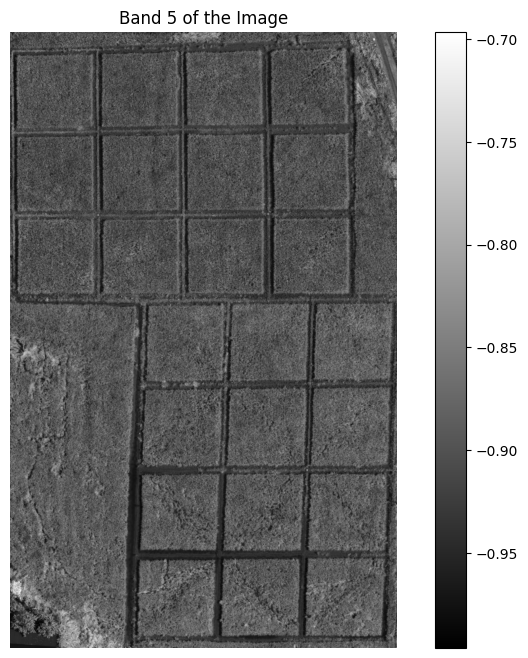

In [38]:
img = tiff.imread(os.path.join(data_path, 'mband/01.tif')).transpose([1, 2, 0])
inp = normalize(img)
display_band_of_whole_image(inp)

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import math

def display_first_100_patches_band(image, patch_size=DEFAULT_PATCH_SIZE, band_index=0):
    """
    Display band 5 of the first 100 patches of the image.

    :param image: The input image with multiple bands.
    :param patch_size: The size of the patches. Default is 128.
    :param band_index: The index of the band to display. Default is 4 (band 5).
    """
    img_height, img_width, nb_channels = image.shape
    if nb_channels <= band_index:
        raise ValueError("Band index out of range. The image has fewer bands than the specified index.")

    # Calculate the number of patches and ensure there are at least 100
    nb_patches_vertical = math.ceil(img_height / patch_size)
    nb_patches_horizontal = math.ceil(img_width / patch_size)
    total_patches = nb_patches_vertical * nb_patches_horizontal
    if total_patches < 10:
        raise ValueError("The image does not contain enough patches to display 10.")

    # Create a figure for displaying the patches
    fig, axes = plt.subplots(5, 5, figsize=(5, 5))  # 10x10 grid for the first 100 patches

    # Process and display each patch
    patch_count = 0
    for i in range(nb_patches_vertical):
        for j in range(nb_patches_horizontal):
            if patch_count >= 200:
                break

            x0, x1 = i * patch_size, (i + 1) * patch_size
            y0, y1 = j * patch_size, (j + 1) * patch_size
            patch = image[x0:x1, y0:y1, :]
            
            # Extract band 5 of the patch
            band5_patch = patch[..., band_index]

            # Display the patch
            ax = axes[patch_count // 5, patch_count % 5]
            ax.imshow(band5_patch, cmap='gray')
            ax.axis('off')
            patch_count += 1

        if patch_count >= 100:
            break

    plt.tight_layout()
    plt.show()




In [13]:
def plot_loss_and_accuracy(history):
    plt.figure(figsize=(12, 6))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    
    plt.show()

# Call this function with your history object
plot_loss_and_accuracy(history)


NameError: name 'history' is not defined

In [14]:
ious = []
for i, pred_mask in enumerate(predicted_masks):
    true_mask = test_masks[i]  # Assuming test_masks is your ground truth
    iou = MeanIoU(num_classes=NB_CLASSES)
    iou.update_state(true_mask.flatten(), pred_mask.flatten())
    ious.append(iou.result().numpy())

average_iou = np.mean(ious)
print("Average IoU:", average_iou)


NameError: name 'predicted_masks' is not defined